##Neural Networks - Training

In this lesson, we're going to do continue on from Part 1 [Neural Networks - Forward Pass and Backpropagation](/nn-forward-backprop.ipynb) move on to training the Neural Network.

In the last lesson, we focused on a single Neuron and to optimize its output (activation function value).  In this lesson, we will create a network of multiple Neurons that are organized into layers. This is formally called a **Multi-Layer Perceptron**

The goal of training is to provide inputs to the Neural Network for which outputs are known and then calculating and minimizing the error between what we expect and what the network outputs.

We are first going to make our lives easier by taking the Value object from the previous lesson and updating it so that it automatically calculates **gradients** and does the **backpropagation**, instead of us having to manually and tediously do it each time.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Here is the Value class, but now with the `backward()` function implemented.

In [2]:
class Value:

  # Initialized with the value (data)
  # We also keep track of the children (i.e. which other Values created this one)
  # So for e.g. 3 + 2 = 5.  This current Value is 5 and its children are 3 and 2
  # We also keep track of the operation (plus, multiply, tanh)
  # We also create a label for this Value
  # We also have a self.grad = this maintains the gradient of the *final output* 
  # w.r.t. the current Value object (so dL/df for e.g.)
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 # default gradient is zero
    
    # internal variables used for autograd graph construction
    self._backward = lambda : None
    self._prev = set(_children) # empty set (set for efficiency)
    self._op = _op
    self.label = label

  # This function is what is printed out to console for this Value object
  def __repr__(self):
    return f"Value(data={self.data}, grad={self.grad})"

  # Add this (self) with other and return a new Value
  def __add__(self, other):
    out =  Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad = 1.0 * out.grad # chain rule - remember that '+' just propogates backward
      other.grad = 1.0 * out.grad # chain rule - remember that '+' just propogates backward
    
    out._backward = _backward
    return out

  # Add this (self) with other and return a new Value
  def __mul__(self, other):
    out =  Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad = other.data * out.grad # chain rule - remember that '*' multiples grad with the other childs value
      other.grad = self.data * out.grad # chain rule - remember that '*' jmultiples grad with the other childs value
    
    out._backward = _backward
    return out

  # Activation function (Hyperbolic Tangent - returns value between -1 and 1)
  def tanh(self):
    n = self.data
    t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1) # this is simply how tanh is defined (see Wikipedia)
    out =  Value(t, (self,), label='tanh')
    
    def _backward():
      self.grad = (1 - t**2) * out.grad # chain rule - (1 - tahn^2) times output grad 
    
    out._backward = _backward
    return out

Note the following changes:
1. We have a variable called `_backward` that stores the backward function. By default it is a function that does not do anything, i.e., an empty function.
2. For the \_\_add__ or '+' operation, we added a function (called a closure) that simply propagates out's grad backward (see step-by-step in part1).  Then we set out's _backward to point to this.  The end result is that when the Value object is added to another value object, we calculate the addition as the output and also propagate the value of the output backward to its two inputs.
3. For the \_\_mul__ or '*' operation, we added a function (called a closure) that propagates out's grad backward (see step-by-step in part1). Remember that for multiplcation, via chain rule, each childs gradient is the product of the other childs value and the outputs gradient. Then we set out's _backward to point to this.  The end result is that when the Value object is added to another value object, we calculate the multiplcation as the output and also propagate the value of the output backward to its two inputs.
4. For the tanh() function, we do the same thing. Except remember that if 
  $$ o = tanh(n)$$ 

  then
  
  $$do/dn = 1 - (tanh(n))**2 = 1 - (o)**2$$


Lets first bring in our (black-box) graph drawing code:

In [3]:
# black-box code that draws a DAG for Value objects using graphviz Digraph
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        # dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

Lets re-initialize our single neuron network

$$
y = w_1 x_1 + w_2 x_2 + b
$$

The actual equation we are going to lay out and solve for is to minimize

$$
tanh(y)
$$

or in other words

$$
output = tanh(w_1 x_1 + w_2 x_2 + b)
$$

and we will do the foward pass

In [4]:
# Simple example
# inputs are x1 and x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights are w1 and w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of the neuron
b = Value(6.8813735870195432, label = 'b')  # we randomly chose this (or Andrej did!)
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
# value of neuron
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# output of neuron (taking it through an activation function)
o = n.tanh(); o.label='output'
o.grad = 1.0 # initialize the outputs gradient as 1.0 to start with
o

Value(data=0.7071067811865476, grad=1.0)

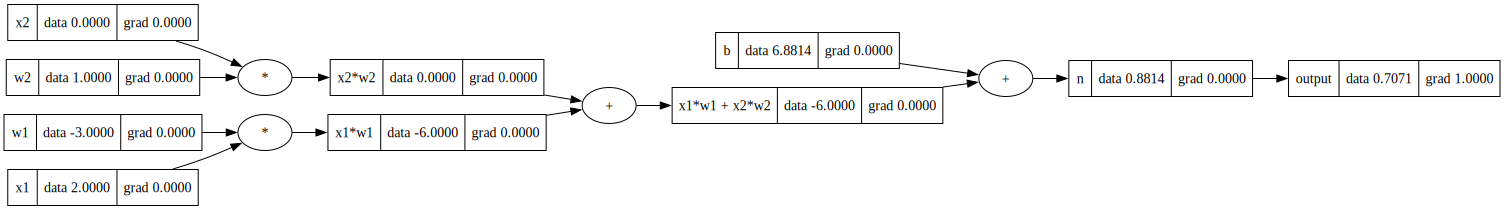

In [5]:
draw_dot(o)

So we have have our foward pass. 

Note that the gradient of the final output is initialized to 1.0. Also notice that the gradients of the rest of the weights and variables are zero.

Now, instead of doing the back-propagation manually, we can just keep calling _backward() starting from the final output and going backward (note that we will shortly write some code that will do that as well.)

Each time we call backward on a Value node, it calculates the gradient of its children based on its own gradient and the chain rule (i.e., it propagates its gradient backward)

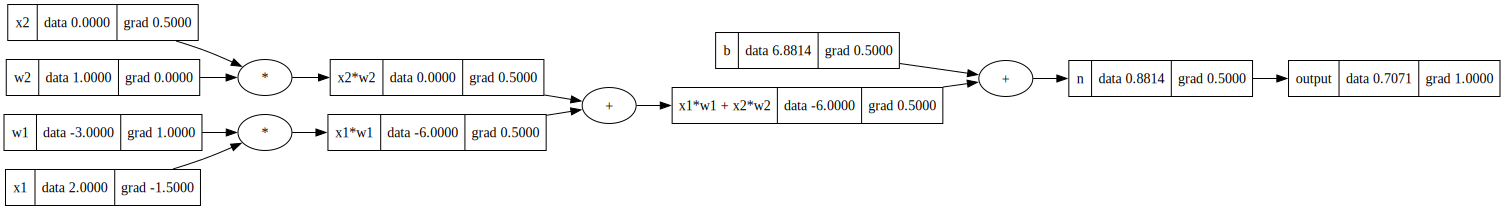

In [6]:
o._backward()
n._backward()
x1w1x2w2._backward()
b._backward() # does nothing by default
x1w1._backward()
x2w2._backward()

draw_dot(o) # redraw our graph - should have all the gradients filled in now

Now, instead of calling _backward() manually on each node in the graph (equation), we can automate it.

In order to do that, we need to order the nodes so that we can call _backward() on them one by one (similar to how we did it manually above).

The code below does that. Specifically note that we modify the Value object to add a new `backward()` function.  

In [7]:
class Value:

  # Initialized with the value (data)
  # We also keep track of the children (i.e. which other Values created this one)
  # So for e.g. 3 + 2 = 5.  This current Value is 5 and its children are 3 and 2
  # We also keep track of the operation (plus, multiply, tanh)
  # We also create a label for this Value
  # We also have a self.grad = this maintains the gradient of the *final output* 
  # w.r.t. the current Value object (so dL/df for e.g.)
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 # default gradient is zero
    
    # internal variables used for autograd graph construction
    self._backward = lambda : None
    self._prev = set(_children) # empty set (set for efficiency)
    self._op = _op
    self.label = label

  # This function is what is printed out to console for this Value object
  def __repr__(self):
    return f"Value(data={self.data}, grad={self.grad})"

  # Add this (self) with other and return a new Value
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out =  Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad # chain rule - remember that '+' just propogates backward
      other.grad += 1.0 * out.grad # chain rule - remember that '+' just propogates backward
    
    out._backward = _backward
    return out

  # Add this (self) with other and return a new Value
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out =  Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad # chain rule - remember that '*' multiples grad with the other childs value
      other.grad += self.data * out.grad # chain rule - remember that '*' jmultiples grad with the other childs value
    
    out._backward = _backward
    return out

  # Activation function (Hyperbolic Tangent - returns value between -1 and 1)
  def tanh(self):
    n = self.data
    t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1) # this is simply how tanh is defined (see Wikipedia)
    out =  Value(t, (self,), label='tanh')
    
    def _backward():
      self.grad = (1 - t**2) * out.grad # chain rule - (1 - tahn^2) times output grad 
    
    out._backward = _backward
    return out

  def backward(self):

    # topologically order all of the children in the graph
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    # go one variable at a time and apply the chain rule to get its gradient
    self.grad = 1
    for v in reversed(topo):
        v._backward()

So now we just need to call `backward()` on the final output node `o` and it should create a list starting with `o` and then going backward, and calls `_backward()` on each one... which does our back-propagation in just one call

**Important Note**: 

One other change we made to the Value object is that we are now accumulating gradients in the `_backword() function`. So you notice we do 

```
self.grad += 1.0 * out.grad
```

the `+=` means that we are setting self.grad to its previous value plus 1.0*out.grad

This is beacuse we have to account for situations when we have

```a + a = b```

In this case, the gradient of b flows backward to a **twice** - so it needs to be `2*b.grad`

In [8]:
# Simple example
# inputs are x1 and x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights are w1 and w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of the neuron
b = Value(6.8813735870195432, label = 'b')  # we randomly chose this (or Andrej did!)
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
# value of neuron
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# output of neuron (taking it through an activation function)
o = n.tanh(); o.label='output'
o.grad = 1.0 # initialize the outputs gradient as 1.0 to start with
o

Value(data=0.7071067811865476, grad=1.0)

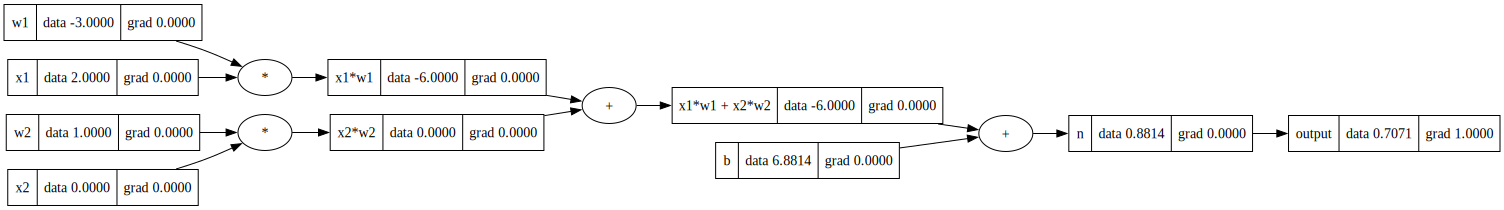

In [9]:
draw_dot(o)

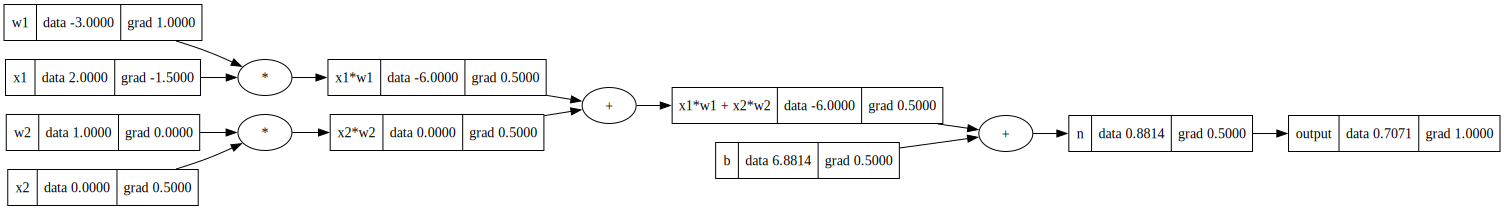

In [10]:
o.backward()

draw_dot(o)

And so, that is backpropagation, but just for one neuron. 

Next, we will create a network of neurons and apply this for that neural network.

First we will enahnce our Value object slightly

In [11]:
class Value:

  # Initialized with the value (data)
  # We also keep track of the children (i.e. which other Values created this one)
  # So for e.g. 3 + 2 = 5.  This current Value is 5 and its children are 3 and 2
  # We also keep track of the operation (plus, multiply, tanh)
  # We also create a label for this Value
  # We also have a self.grad = this maintains the gradient of the *final output* 
  # w.r.t. the current Value object (so dL/df for e.g.)
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 # default gradient is zero
    
    # internal variables used for autograd graph construction
    self._backward = lambda : None
    self._prev = set(_children) # empty set (set for efficiency)
    self._op = _op
    self.label = label

  # This function is what is printed out to console for this Value object
  def __repr__(self):
    return f"Value(data={self.data}, grad={self.grad})"

  # Add this (self) with other and return a new Value
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out =  Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad # chain rule - remember that '+' just propogates backward
      other.grad += 1.0 * out.grad # chain rule - remember that '+' just propogates backward
    
    out._backward = _backward
    return out

  # Add this (self) with other and return a new Value
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out =  Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad # chain rule - remember that '*' multiples grad with the other childs value
      other.grad += self.data * out.grad # chain rule - remember that '*' jmultiples grad with the other childs value
    
    out._backward = _backward
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += (other * self.data**(other-1)) * out.grad
      
    out._backward = _backward
    return out

  # Activation function (Hyperbolic Tangent - returns value between -1 and 1)
  def tanh(self):
    n = self.data
    t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1) # this is simply how tanh is defined (see Wikipedia)
    out =  Value(t, (self,), label='tanh')
    
    def _backward():
      self.grad = (1 - t**2) * out.grad # chain rule - (1 - tahn^2) times output grad 
    
    out._backward = _backward
    return out

  def backward(self):

    # topologically order all of the children in the graph
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    # go one variable at a time and apply the chain rule to get its gradient
    self.grad = 1
    for v in reversed(topo):
        v._backward()
        
  def __neg__(self): # -self
    return self * -1

  def __radd__(self, other): # other + self
    return self + other

  def __sub__(self, other): # self - other
    return self + (-other)

  def __rsub__(self, other): # other - self
    return other + (-self)

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __rtruediv__(self, other): # other / self
    return other * self**-1

<< Explanation of new functions goes here >>

Lets now create a Neuron. In our case it is the Python class below.

In [12]:
import random

class Neuron:

    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.tanh() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

- `nin` is the number of inputs to this Neuron (i.e. $x1, x2, \dots, xn$)
- `w` is a list of weights for each input (i.e. $w1, w2, \dots, wn$)
- `b` is the bias

so together these comprise the equation:

$$
y = w_1 x_1 + w_2 x_2 + \dots + b
$$

- the function `__call()__` calculates the forward pass for this Neuron.  When you invoke the neuron with a list of inputs then Python invokes the `__call()__` function.  E.g. `n(x)`. We will pass in Value objects for each `x` and each weight `w` is also a Value object. Therefore the sum is another Value object and remember that the Value has a `tanh()` function.  So the function `__call()__` returns $tanh(y)$ which is a number between -1 and 1


Remember our goal is to create a Neural Network that looks like this

![Simple Neural Network](https://cs231n.github.io/assets/nn1/neural_net.jpeg)

It has one input layer and one output layer.. and a layer in between called the hidden layer

Note: The difference between the terms **shallow** and **deep* neural networks is simply that deep neural networks contain more than two hidden layers. In reality, modern neural networks used to train Large Language models can contain millions of hidden layers, billions of neurons and trillions of connections between them

We have already created an individual Neuron.  Now lets create one layer of neurons.

In [13]:
class Layer():

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

- Each layer contains a list of neurons `self.neurons`
- `nin` is the number of inputs to each Neuron
- `nout` is the number of number of Neurons (and number of outputs) for this layer


In [14]:
x = [2.0, 3.0] # we have two inputs
n = Layer(2, 3) # we create a layer containing 3 neurons, each with two inputs
n

Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)]

And finally lets define the entire network - which is the layers of neurons - also called a **Multi-Layer Perceptron**

In [15]:
class MLP():

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

- Each MLP contains a list of Layers (`self.layers`)
- It takes `nouts` as a list of nouts or Layers and creates as many as required and stores in self.layers
- It also takes `nin` - the number of inputs and passes that to each layer

In [16]:
x = [2.0, 3.0 -1] # we have two inputs
n = MLP(2, [4, 4, 1]) # we create a layer containing 3 neurons, each with two inputs
n

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(4), ReLUNeuron(4), ReLUNeuron(4), ReLUNeuron(4)], Layer of [ReLUNeuron(4)]]

In [17]:
n(x) # forward pass

Value(data=-0.16715214091752748, grad=0.0)

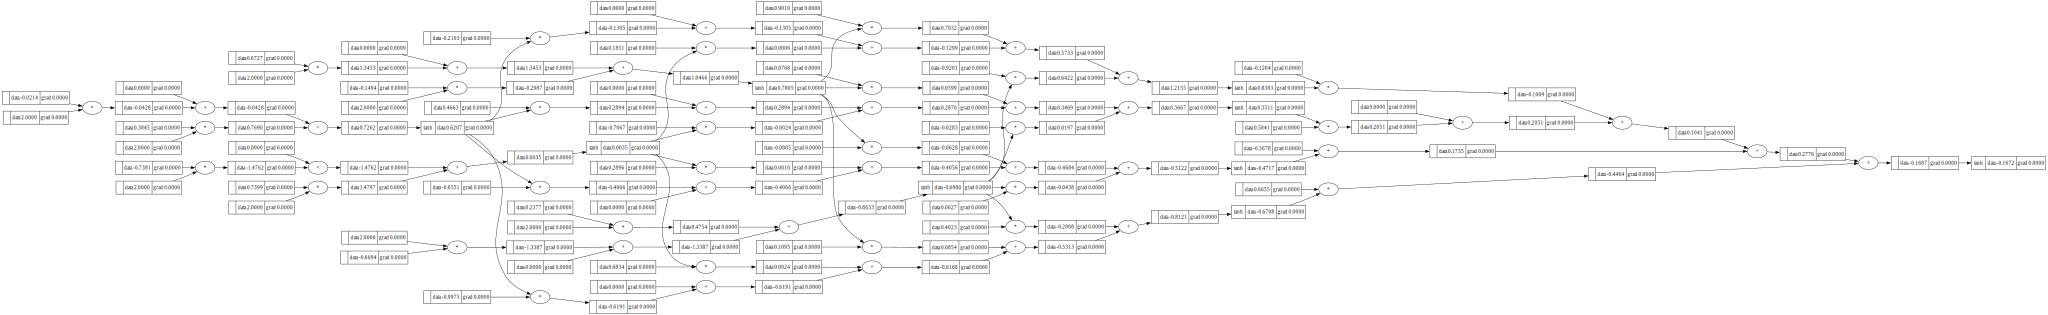

In [18]:
draw_dot(n(x))

- the graph plot above is very complex and will get even more so with more neurons and more layers in the MLP.  
- it is best to keep our original neuron problem that we solved at the outset of this lesson in mind and be comforted that at the core that is what is happening

Next we will
 - create a sample dataset
 - define the loss function (explanation below)
 - train the neural net with the dataset to minize the loss function. We will use manual backpropagation for this

#### Dataset
Lets use a labeled dataset $(xi, yi)$ where $i = 4$. 

The dataset below has four sets of four inputs (xs) and four labels (ys, one for each set of inputs)

In [19]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

so for the first input set (i = 1)

$$
y = w1 x1 + w2 x2 + w3 x3 + b
$$

or 

$$
1.0 = w1 * 2 + w2 * 3.0 + w3 * -1.0 + b
$$

So the goal of our training is to find $w1$, $w2$, $w3$ and $b$ such that the equation above returns the value 1.0 for the input x = [2.0, 3.0, -1.0] and also the desired y for the other inputs

#### Calculating and Optimizing the Loss

We can use the dataset to generate a set of predictions to get started.

Remember that each Neuron gets a random weight the first time

```
self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
```

In [20]:
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.25564927763071404, grad=0.0),
 Value(data=-0.07064277749029342, grad=0.0),
 Value(data=-0.10002414226348157, grad=0.0),
 Value(data=-0.13415274786729797, grad=0.0)]

As can be seen the four predictions are quite far from the expected values of

$$
ys = [1.0, -1.0, -1.0, 1.0]
$$

So now we figure out a loss, which is simply a function of the difference between the expected and predicted value.

So $y_{pred} - y_{gt}$, where "gt" stands for ground truth

More specifically we want to calculate the mean square error loss which is 

$$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_{pred_i} - y_{gt_i})^2$$

Where:
- $n$ is the number of samples
- $y_{pred_i}$ is the predicted value for the $i$-th sample
- $y_{gt_i}$ is the ground truth (actual) value for the $i$-th sample

Note that squaring the loss is better since it makes sure to handle extermely small losses (doubles) and also negative losse (makes positive) - thus giving us stable values for loss.  This is instead of for e.g. taking just the absolute value of the loss.

In [21]:
[(ypred - ygt)**2 for ygt, ypred in zip(ys, ypred)]

[Value(data=1.576655108414534, grad=0.0),
 Value(data=0.8637048470309562, grad=0.0),
 Value(data=0.8099565445085821, grad=0.0),
 Value(data=1.2863024554949427, grad=0.0)]

Our goal is to get each of the values above to be as close to zero as possible.

In [22]:
loss = sum([(ypred - ygt)**2 for ygt, ypred in zip(ys, ypred)])
loss.grad = 1.0
loss

Value(data=4.536618955449015, grad=1.0)

So our loss is high and we need to get it close to zero.  When that happens, it implies that each of the predictions is as close to ground truth as possible.

Lets do a first backprop now...

In [23]:
loss.backward()
print("weight for first neuron of first layer =", n.layers[0].neurons[0].w[0])

weight for first neuron of first layer = Value(data=-0.02140937196426762, grad=-0.2659713907144926)


So it has an extermely high gradient - which indicates that making it smaller would move us in the correct direction toward the minima.  

And, the same holds true for all the other weights of all the other neurons in this MLP.

So, in order to do our optimization, which consists of adjusting the weights based on their gradients, we need to first collect only the weights from the neural net.

Note that the Neuron class already has

```
def parameters(self):
    return self.w + [self.b]
```

and the layer

```
def parameters(self):
    return [p for n in self.neurons for p in n.parameters()]
```

and the MLP

```
def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]
```

Therefore we can get parameters for the MLP

In [24]:
n.parameters()

[Value(data=-0.02140937196426762, grad=-0.2659713907144926),
 Value(data=0.3844897680656265, grad=0.08343994772326338),
 Value(data=0, grad=-0.17910532613757146),
 Value(data=-0.7381222588705736, grad=0.6713667164968229),
 Value(data=0.7398513975764447, grad=0.8280525775730638),
 Value(data=0, grad=0.3825476959076683),
 Value(data=0.6726691605326842, grad=-0.24334862699122226),
 Value(data=-0.14937437940796428, grad=-0.34455515605010284),
 Value(data=0, grad=-0.12549694261095273),
 Value(data=-0.6693693237426093, grad=-0.8157295478048683),
 Value(data=0.23769639913498164, grad=-0.9279589589566204),
 Value(data=0, grad=-0.21204597712396644),
 Value(data=0.466293145054683, grad=-1.4861507012914403),
 Value(data=-0.7067322418135924, grad=-1.2569395250867008),
 Value(data=0.07680227703147424, grad=-0.645412804729276),
 Value(data=-0.028257364513169847, grad=0.4231152007263834),
 Value(data=0, grad=-0.8193122822658199),
 Value(data=-0.21032320370652124, grad=0.07800987050941231),
 Value(dat

Now that we have parameters, lets optimize weights by incrementing them **opposite** to the direction of the gradient (which is why we add a negative sign)

In [25]:
step_size = 0.01
for p in n.parameters():
    p.data += -step_size * p.grad

In [26]:
print("weight for first neuron of first layer =", n.layers[0].neurons[0].w[0])

weight for first neuron of first layer = Value(data=-0.018749658057122694, grad=-0.2659713907144926)


Now that we have new weights, lets repeat the cycle of
- forward pass
- calculate loss
- backpropagate gradients
- optimize values of weights and biases further

In [27]:
# forward pass
ypred = [n(x) for x in xs]

# calculate loss
loss = sum([(ypred - ygt)**2 for ygt, ypred in zip(ys, ypred)])
loss

Value(data=4.366369166079245, grad=0.0)

In [28]:
# backpropagate
loss.backward()

# optimize/adjust values
for p in n.parameters():
    p.data += -step_size * p.grad

Next epoch/iteration

In [29]:
# forward pass
ypred = [n(x) for x in xs]

# calculate loss
loss = sum([(ypred - ygt)**2 for ygt, ypred in zip(ys, ypred)])
loss

Value(data=4.090816027623287, grad=0.0)

In [30]:
# backpropagate
loss.backward()

# optimize/adjust values
for p in n.parameters():
    p.data += -step_size * p.grad

In [31]:
# forward pass
ypred = [n(x) for x in xs]

# calculate loss
loss = sum([(ypred - ygt)**2 for ygt, ypred in zip(ys, ypred)])
loss

Value(data=3.8171197213244468, grad=0.0)

As can be seen, after three epochs, the loss seems to be going downward

In [32]:
ypred

[Value(data=0.12853815053103287, grad=0.0),
 Value(data=-0.011395592753560307, grad=0.0),
 Value(data=0.11976813483028152, grad=0.0),
 Value(data=0.09090450642619394, grad=0.0)]

Instead of running the steps manually each time, lets create a **training loop**

In [33]:
for epoch in range(100):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(ypred - ygt)**2 for ygt, ypred in zip(ys, ypred)])
    
    # backpropagate
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -step_size * p.grad

In [34]:
loss

Value(data=8.608577730577318e-06, grad=1)

The loss is a very small number - 0.00000086

In [35]:
ypred

[Value(data=0.9999999999999986, grad=-2.886579864025407e-15),
 Value(data=-0.9999999065972982, grad=1.8680540359028441e-07),
 Value(data=-0.9997439183393735, grad=0.0005121633212530341),
 Value(data=0.9970771589326575, grad=-0.00584568213468506)]

And our predicted values are very close to ground truth

$$
ys = [1.0, -1.0, -1.0, 1.0]
$$

We have successfully trained our first neural network!!!!